In [87]:
! pip3 install pandas pycoingecko matplotlib scipy seaborn
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import datetime as dt
import time
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycoingecko import CoinGeckoAPI
from statsmodels.graphics.tsaplots import plot_acf
cg = CoinGeckoAPI()

In [88]:
tweet_date = "2018-07-18 01:58:00"
coin='dogecoin'
date_format = "%Y-%m-%d %H:%M:%S"
#1 day from current time will produce 5min interval
#1-90 hourly interval
#above 90 days is daily
number_of_days = 7
number_of_hours = 0
tweet_datetime = pd.to_datetime(tweet_date,format=date_format)
tweet_from_timestamp = (tweet_datetime - dt.timedelta(days=number_of_days,hours=number_of_hours)).timestamp()
tweet_to_timestamp = (tweet_datetime + dt.timedelta(days=number_of_days,hours=number_of_hours)).timestamp()

In [89]:
coin_gecko_data = cg.get_coin_market_chart_range_by_id(id=coin,
                                                vs_currency='usd',
                                                from_timestamp=tweet_from_timestamp,
                                                to_timestamp=tweet_to_timestamp)

In [90]:
def get_nth_element():
    return l[1]
parsed_data = {}
timestamps=list(map(lambda x:x[0],coin_gecko_data['prices']))
for key in coin_gecko_data.keys():
    parsed_data[key] = list(map(lambda x:x[1], coin_gecko_data[key]))
parsed_data['timestamps']=timestamps

In [91]:
df=pd.DataFrame(parsed_data)

In [92]:
df

,prices,market_caps,total_volumes,timestamps
0,0.002414,2.781948e+08,5.878091e+06,1531274641822
1,0.002390,2.754051e+08,5.814493e+06,1531278243619
2,0.002374,2.735420e+08,5.769283e+06,1531281843634
3,0.002402,2.768033e+08,5.878266e+06,1531285435984
4,0.002397,2.761497e+08,5.712269e+06,1531289038750
...,...,...,...,...
343,0.003564,4.113077e+08,8.979023e+06,1532467396959
344,0.003609,4.165872e+08,9.435907e+06,1532470997821
345,0.003613,4.170488e+08,9.702996e+06,1532474601026
346,0.003629,4.188769e+08,9.841426e+06,1532478200458


In [93]:
df['timestamps'].head()

0    1531274641822
1    1531278243619
2    1531281843634
3    1531285435984
4    1531289038750
Name: timestamps, dtype: int64

In [94]:
df['date']=pd.to_datetime(df['timestamps'],origin='unix',unit='ms')

In [95]:
df

,prices,market_caps,total_volumes,timestamps,date
0,0.002414,2.781948e+08,5.878091e+06,1531274641822,2018-07-11 02:04:01.822
1,0.002390,2.754051e+08,5.814493e+06,1531278243619,2018-07-11 03:04:03.619
2,0.002374,2.735420e+08,5.769283e+06,1531281843634,2018-07-11 04:04:03.634
3,0.002402,2.768033e+08,5.878266e+06,1531285435984,2018-07-11 05:03:55.984
4,0.002397,2.761497e+08,5.712269e+06,1531289038750,2018-07-11 06:03:58.750
...,...,...,...,...,...
343,0.003564,4.113077e+08,8.979023e+06,1532467396959,2018-07-24 21:23:16.959
344,0.003609,4.165872e+08,9.435907e+06,1532470997821,2018-07-24 22:23:17.821
345,0.003613,4.170488e+08,9.702996e+06,1532474601026,2018-07-24 23:23:21.026
346,0.003629,4.188769e+08,9.841426e+06,1532478200458,2018-07-25 00:23:20.458


In [96]:
def is_after_tweet(date):
    if date < tweet_datetime:
        return 0
    elif date > tweet_datetime:
        return 1
    else:
        return -1

In [97]:
df['before/after']=df['date'].map(is_after_tweet)

In [98]:
def gen_days_since(date):
    diff = date - tweet_datetime
    return  diff.days + (diff.seconds / (3600 * 24))

In [99]:
gen_days_since(tweet_datetime)

0.0

In [100]:
df['days_since_tweet']=df['date'].map(gen_days_since)

In [101]:
df

,prices,market_caps,total_volumes,timestamps,date,before/after,days_since_tweet
0,0.002414,2.781948e+08,5.878091e+06,1531274641822,2018-07-11 02:04:01.822,0,-6.995822
1,0.002390,2.754051e+08,5.814493e+06,1531278243619,2018-07-11 03:04:03.619,0,-6.954132
2,0.002374,2.735420e+08,5.769283e+06,1531281843634,2018-07-11 04:04:03.634,0,-6.912465
3,0.002402,2.768033e+08,5.878266e+06,1531285435984,2018-07-11 05:03:55.984,0,-6.870891
4,0.002397,2.761497e+08,5.712269e+06,1531289038750,2018-07-11 06:03:58.750,0,-6.829190
...,...,...,...,...,...,...,...
343,0.003564,4.113077e+08,8.979023e+06,1532467396959,2018-07-24 21:23:16.959,1,6.809213
344,0.003609,4.165872e+08,9.435907e+06,1532470997821,2018-07-24 22:23:17.821,1,6.850891
345,0.003613,4.170488e+08,9.702996e+06,1532474601026,2018-07-24 23:23:21.026,1,6.892604
346,0.003629,4.188769e+08,9.841426e+06,1532478200458,2018-07-25 00:23:20.458,1,6.934259


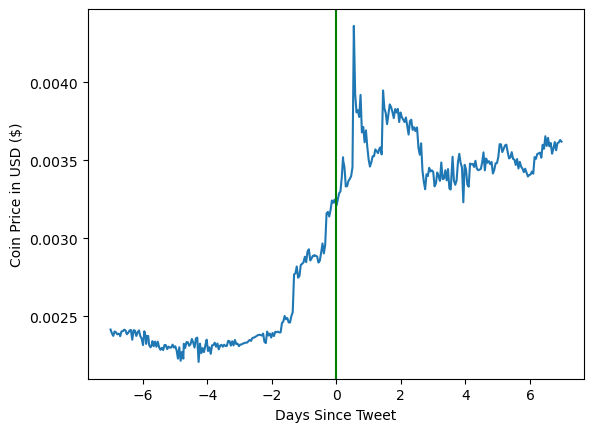

In [102]:
df.plot(x='days_since_tweet',y='prices',legend=False,ylabel='Coin Price in USD ($)',xlabel='Days Since Tweet')
plt.axvline(0,color='green')

In [103]:
max_price =max(df['prices'])

In [104]:
min_price = min(df['prices'])

In [105]:
def min_max(price):
    return (price - min_price)/(max_price-min_price)

In [106]:
df['min_max_prices']=df['prices'].map(min_max)

In [107]:
df

,prices,market_caps,total_volumes,timestamps,date,before/after,days_since_tweet,min_max_prices
0,0.002414,2.781948e+08,5.878091e+06,1531274641822,2018-07-11 02:04:01.822,0,-6.995822,0.096332
1,0.002390,2.754051e+08,5.814493e+06,1531278243619,2018-07-11 03:04:03.619,0,-6.954132,0.085090
2,0.002374,2.735420e+08,5.769283e+06,1531281843634,2018-07-11 04:04:03.634,0,-6.912465,0.077582
3,0.002402,2.768033e+08,5.878266e+06,1531285435984,2018-07-11 05:03:55.984,0,-6.870891,0.090724
4,0.002397,2.761497e+08,5.712269e+06,1531289038750,2018-07-11 06:03:58.750,0,-6.829190,0.088090
...,...,...,...,...,...,...,...,...
343,0.003564,4.113077e+08,8.979023e+06,1532467396959,2018-07-24 21:23:16.959,1,6.809213,0.629987
344,0.003609,4.165872e+08,9.435907e+06,1532470997821,2018-07-24 22:23:17.821,1,6.850891,0.651228
345,0.003613,4.170488e+08,9.702996e+06,1532474601026,2018-07-24 23:23:21.026,1,6.892604,0.653085
346,0.003629,4.188769e+08,9.841426e+06,1532478200458,2018-07-25 00:23:20.458,1,6.934259,0.660439


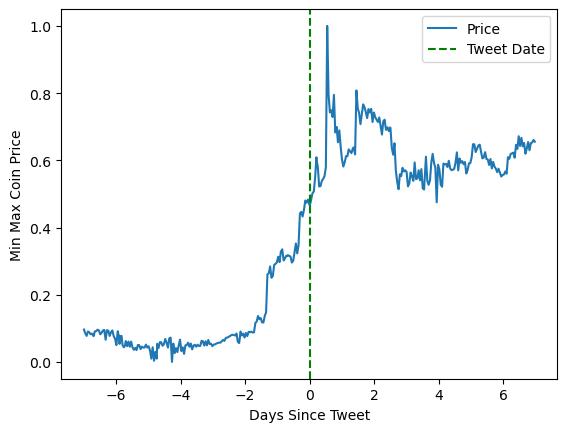

In [108]:
df.plot(x='days_since_tweet',y='min_max_prices',legend=False,ylabel='Min Max Coin Price',xlabel='Days Since Tweet')
plt.axvline(0,color='green',linestyle='--')
plt.legend(('Price','Tweet Date'))

[Text(1, 0, 'Coin Prices After Tweet')]

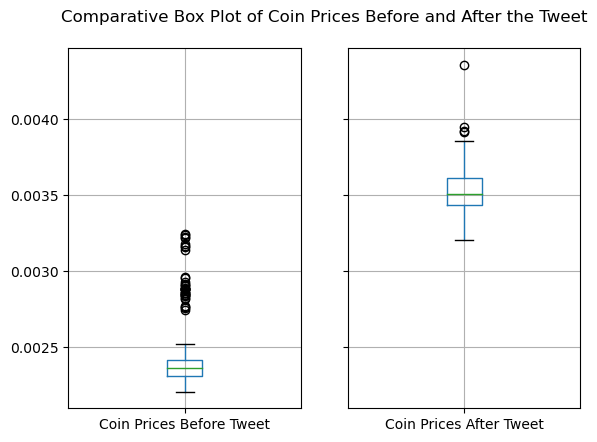

In [176]:
axes=df.groupby(by='before/after').boxplot(column='prices',subplots=True)
axes[0].set_title('')
axes[1].set_title('')
plt.suptitle('Comparative Box Plot of Coin Prices Before and After the Tweet')
axes[0].set_xticklabels(['Coin Prices Before Tweet'])
axes[1].set_xticklabels(['Coin Prices After Tweet'])

In [110]:
df.groupby(by='before/after')['prices'].describe()

,count,mean,std,min,25%,50%,75%,max
before/after,,,,,,,,
0,174.0,0.002464,0.000250,0.002207,0.002315,0.002365,0.002414,0.003248
1,174.0,0.003540,0.000163,0.003209,0.003435,0.003508,0.003613,0.004360


In [111]:
df['prices'].autocorr(lag=1)

0.990426757985195

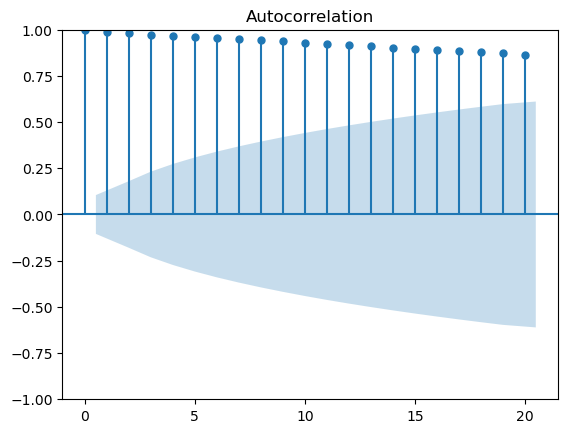

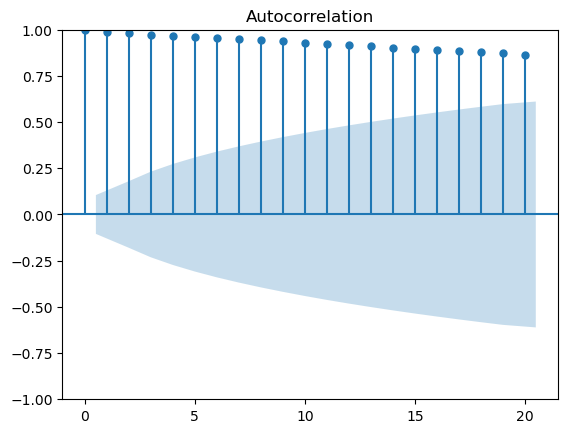

In [114]:
plot_acf(df['prices'],lags=20)